In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [23]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [24]:
class DNN(nn.Module):
    def __init__(self, input_dim,hidden_units,dropout_rate):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units)
        self.layer2 = nn.Linear(hidden_units,hidden_units)
        self.layer3 = nn.Linear(hidden_units, hidden_units)
        self.layer4 = nn.Linear(hidden_units, hidden_units)
        self.output_layer = nn.Linear(hidden_units, 1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(hidden_units)
        self.bn2 = nn.BatchNorm1d(hidden_units)
        self.bn3 = nn.BatchNorm1d(hidden_units)
        self.bn4 = nn.BatchNorm1d(hidden_units)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [25]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [26]:
def objective(trial):
    hidden_units = trial.suggest_int("hidden_units", 4, 512, step=4)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    model = DNN(input_dim=X_train_tensor.shape[1], hidden_units=hidden_units, dropout_rate=dropout_rate).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return f1


In [ ]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


最適化

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 14:34:05,622] A new study created in memory with name: no-name-94acb166-b411-46c1-a71e-5b4db34779e1
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:35:04,001] Trial 0 finished with value: 0.45901639344262296 and parameters: {'hidden_units': 392, 'dropout_rate': 0.25, 'learning_rate': 0.00455345913278926}. Best is trial 0 with value: 0.45901639344262296.


Accuracy: 62.39%
Precision: 0.4746
Recall: 0.4444
F1 Score: 0.4590
Matthews Correlation Coefficient: 0.1715
Specificity: 0.7244


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:35:59,346] Trial 1 finished with value: 0.46774193548387094 and parameters: {'hidden_units': 448, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0024446970901326817}. Best is trial 1 with value: 0.46774193548387094.


Accuracy: 62.39%
Precision: 0.4754
Recall: 0.4603
F1 Score: 0.4677
Matthews Correlation Coefficient: 0.1772
Specificity: 0.7156


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:36:49,681] Trial 2 finished with value: 0.5130111524163569 and parameters: {'hidden_units': 360, 'dropout_rate': 0.15000000000000002, 'learning_rate': 5.964965377177962e-05}. Best is trial 2 with value: 0.5130111524163569.


Accuracy: 62.68%
Precision: 0.4825
Recall: 0.5476
F1 Score: 0.5130
Matthews Correlation Coefficient: 0.2135
Specificity: 0.6711


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:37:34,316] Trial 3 finished with value: 0.4424778761061947 and parameters: {'hidden_units': 176, 'dropout_rate': 0.35, 'learning_rate': 0.0005370665438447742}. Best is trial 2 with value: 0.5130111524163569.


Accuracy: 64.10%
Precision: 0.5000
Recall: 0.3968
F1 Score: 0.4425
Matthews Correlation Coefficient: 0.1856
Specificity: 0.7778


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:38:24,156] Trial 4 finished with value: 0.4946236559139785 and parameters: {'hidden_units': 136, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0005078847098430226}. Best is trial 2 with value: 0.5130111524163569.


Accuracy: 59.83%
Precision: 0.4510
Recall: 0.5476
F1 Score: 0.4946
Matthews Correlation Coefficient: 0.1686
Specificity: 0.6267


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:39:20,308] Trial 5 finished with value: 0.45977011494252873 and parameters: {'hidden_units': 236, 'dropout_rate': 0.25, 'learning_rate': 0.018333788418612974}. Best is trial 2 with value: 0.5130111524163569.


Accuracy: 59.83%
Precision: 0.4444
Recall: 0.4762
F1 Score: 0.4598
Matthews Correlation Coefficient: 0.1409
Specificity: 0.6667


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:40:11,581] Trial 6 finished with value: 0.44621513944223107 and parameters: {'hidden_units': 248, 'dropout_rate': 0.35, 'learning_rate': 0.0022493696167696703}. Best is trial 2 with value: 0.5130111524163569.


Accuracy: 60.40%
Precision: 0.4480
Recall: 0.4444
F1 Score: 0.4462
Matthews Correlation Coefficient: 0.1380
Specificity: 0.6933


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:41:00,429] Trial 7 finished with value: 0.0 and parameters: {'hidden_units': 8, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.013107657382078076}. Best is trial 2 with value: 0.5130111524163569.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 14:41:48,440] Trial 8 finished with value: 0.5415162454873647 and parameters: {'hidden_units': 28, 'dropout_rate': 0.25, 'learning_rate': 0.0025221721477473426}. Best is trial 8 with value: 0.5415162454873647.


Accuracy: 63.82%
Precision: 0.4967
Recall: 0.5952
F1 Score: 0.5415
Matthews Correlation Coefficient: 0.2494
Specificity: 0.6622


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:42:42,537] Trial 9 finished with value: 0.5130111524163569 and parameters: {'hidden_units': 360, 'dropout_rate': 0.1, 'learning_rate': 1.1630970959476067e-05}. Best is trial 8 with value: 0.5415162454873647.


Accuracy: 62.68%
Precision: 0.4825
Recall: 0.5476
F1 Score: 0.5130
Matthews Correlation Coefficient: 0.2135
Specificity: 0.6711


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:43:36,032] Trial 10 finished with value: 0.6217616580310881 and parameters: {'hidden_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.06061628011534399}. Best is trial 10 with value: 0.6217616580310881.


Accuracy: 58.40%
Precision: 0.4615
Recall: 0.9524
F1 Score: 0.6218
Matthews Correlation Coefficient: 0.3614
Specificity: 0.3778


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:44:26,573] Trial 11 finished with value: 0.0 and parameters: {'hidden_units': 20, 'dropout_rate': 0.5, 'learning_rate': 0.0574505844603973}. Best is trial 10 with value: 0.6217616580310881.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 14:45:13,434] Trial 12 finished with value: 0.6297229219143576 and parameters: {'hidden_units': 96, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.08042899832693882}. Best is trial 12 with value: 0.6297229219143576.


Accuracy: 58.12%
Precision: 0.4613
Recall: 0.9921
F1 Score: 0.6297
Matthews Correlation Coefficient: 0.3924
Specificity: 0.3511


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:46:00,385] Trial 13 finished with value: 0.6313131313131313 and parameters: {'hidden_units': 116, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.079098397867244}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.40%
Precision: 0.4630
Recall: 0.9921
F1 Score: 0.6313
Matthews Correlation Coefficient: 0.3958
Specificity: 0.3556


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:46:54,292] Trial 14 finished with value: 0.0 and parameters: {'hidden_units': 132, 'dropout_rate': 0.4, 'learning_rate': 0.07114246056369661}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 14:47:39,630] Trial 15 finished with value: 0.6153846153846154 and parameters: {'hidden_units': 104, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.014990928265668429}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.69%
Precision: 0.4622
Recall: 0.9206
F1 Score: 0.6154
Matthews Correlation Coefficient: 0.3408
Specificity: 0.4000


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:48:33,059] Trial 16 finished with value: 0.6313131313131313 and parameters: {'hidden_units': 204, 'dropout_rate': 0.4, 'learning_rate': 0.09243853684083232}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.40%
Precision: 0.4630
Recall: 0.9921
F1 Score: 0.6313
Matthews Correlation Coefficient: 0.3958
Specificity: 0.3556


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:49:30,913] Trial 17 finished with value: 0.45136186770428016 and parameters: {'hidden_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.00011740507792855675}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 59.83%
Precision: 0.4427
Recall: 0.4603
F1 Score: 0.4514
Matthews Correlation Coefficient: 0.1348
Specificity: 0.6756


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:50:30,400] Trial 18 finished with value: 0.5669781931464174 and parameters: {'hidden_units': 296, 'dropout_rate': 0.4, 'learning_rate': 0.025731282573515882}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.40%
Precision: 0.4667
Recall: 0.7222
F1 Score: 0.5670
Matthews Correlation Coefficient: 0.2510
Specificity: 0.5378


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:51:21,293] Trial 19 finished with value: 0.44081632653061226 and parameters: {'hidden_units': 308, 'dropout_rate': 0.35, 'learning_rate': 0.006809920703067092}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.97%
Precision: 0.4538
Recall: 0.4286
F1 Score: 0.4408
Matthews Correlation Coefficient: 0.1415
Specificity: 0.7111


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:52:11,759] Trial 20 finished with value: 0.0 and parameters: {'hidden_units': 196, 'dropout_rate': 0.5, 'learning_rate': 0.03472350164813138}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:53:01,477] Trial 21 finished with value: 0.0 and parameters: {'hidden_units': 88, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0950714845926813}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 14:53:45,652] Trial 22 finished with value: 0.6240409207161125 and parameters: {'hidden_units': 152, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.02885447450774649}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.12%
Precision: 0.4604
Recall: 0.9683
F1 Score: 0.6240
Matthews Correlation Coefficient: 0.3711
Specificity: 0.3644


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:54:36,513] Trial 23 finished with value: 0.5623003194888179 and parameters: {'hidden_units': 72, 'dropout_rate': 0.4, 'learning_rate': 0.008823546880082567}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.97%
Precision: 0.4706
Recall: 0.6984
F1 Score: 0.5623
Matthews Correlation Coefficient: 0.2485
Specificity: 0.5600


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:55:25,725] Trial 24 finished with value: 0.0 and parameters: {'hidden_units': 240, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.09927710030136998}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 14:56:16,793] Trial 25 finished with value: 0.6259541984732825 and parameters: {'hidden_units': 104, 'dropout_rate': 0.5, 'learning_rate': 0.04604986699895319}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.12%
Precision: 0.4607
Recall: 0.9762
F1 Score: 0.6260
Matthews Correlation Coefficient: 0.3780
Specificity: 0.3600


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:57:11,395] Trial 26 finished with value: 0.6137566137566137 and parameters: {'hidden_units': 204, 'dropout_rate': 0.35, 'learning_rate': 0.02765020081332885}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.40%
Precision: 0.4603
Recall: 0.9206
F1 Score: 0.6138
Matthews Correlation Coefficient: 0.3371
Specificity: 0.3956


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:58:02,057] Trial 27 finished with value: 0.5 and parameters: {'hidden_units': 500, 'dropout_rate': 0.4, 'learning_rate': 0.005667380812305884}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 63.53%
Precision: 0.4923
Recall: 0.5079
F1 Score: 0.5000
Matthews Correlation Coefficient: 0.2132
Specificity: 0.7067


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 14:58:55,443] Trial 28 finished with value: 0.4852941176470588 and parameters: {'hidden_units': 52, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.010899222111245442}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.11%
Precision: 0.4521
Recall: 0.5238
F1 Score: 0.4853
Matthews Correlation Coefficient: 0.1638
Specificity: 0.6444


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 14:59:47,332] Trial 29 finished with value: 0.0 and parameters: {'hidden_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.043661554352565905}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:00:37,732] Trial 30 finished with value: 0.4860557768924303 and parameters: {'hidden_units': 280, 'dropout_rate': 0.5, 'learning_rate': 0.0011204686450142036}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 63.25%
Precision: 0.4880
Recall: 0.4841
F1 Score: 0.4861
Matthews Correlation Coefficient: 0.2000
Specificity: 0.7156


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:01:29,564] Trial 31 finished with value: 0.6201550387596899 and parameters: {'hidden_units': 108, 'dropout_rate': 0.5, 'learning_rate': 0.045897572642544036}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.12%
Precision: 0.4598
Recall: 0.9524
F1 Score: 0.6202
Matthews Correlation Coefficient: 0.3578
Specificity: 0.3733


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:02:14,577] Trial 32 finished with value: 0.0 and parameters: {'hidden_units': 120, 'dropout_rate': 0.5, 'learning_rate': 0.07566001890236289}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:02:58,085] Trial 33 finished with value: 0.0 and parameters: {'hidden_units': 216, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.018638748604629947}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:03:48,562] Trial 34 finished with value: 0.0 and parameters: {'hidden_units': 56, 'dropout_rate': 0.4, 'learning_rate': 0.03678190271700277}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:04:31,590] Trial 35 finished with value: 0.39473684210526316 and parameters: {'hidden_units': 172, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.0036566450933684536}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.68%
Precision: 0.4412
Recall: 0.3571
F1 Score: 0.3947
Matthews Correlation Coefficient: 0.1097
Specificity: 0.7467


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:05:22,704] Trial 36 finished with value: 0.46153846153846156 and parameters: {'hidden_units': 96, 'dropout_rate': 0.35, 'learning_rate': 0.00031685114268807294}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.11%
Precision: 0.4478
Recall: 0.4762
F1 Score: 0.4615
Matthews Correlation Coefficient: 0.1454
Specificity: 0.6711


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:05:59,053] Trial 37 finished with value: 0.6230366492146597 and parameters: {'hidden_units': 152, 'dropout_rate': 0.5, 'learning_rate': 0.019486146831952104}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.97%
Precision: 0.4648
Recall: 0.9444
F1 Score: 0.6230
Matthews Correlation Coefficient: 0.3623
Specificity: 0.3911


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:06:45,424] Trial 38 finished with value: 0.6262626262626263 and parameters: {'hidden_units': 132, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.09791582110935998}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 57.83%
Precision: 0.4593
Recall: 0.9841
F1 Score: 0.6263
Matthews Correlation Coefficient: 0.3817
Specificity: 0.3511


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:07:20,081] Trial 39 finished with value: 0.0 and parameters: {'hidden_units': 136, 'dropout_rate': 0.2, 'learning_rate': 0.09620588500038878}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:08:06,907] Trial 40 finished with value: 0.5838509316770186 and parameters: {'hidden_units': 224, 'dropout_rate': 0.30000000000000004, 'learning_rate': 2.6815610666439873e-05}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 61.82%
Precision: 0.4796
Recall: 0.7460
F1 Score: 0.5839
Matthews Correlation Coefficient: 0.2828
Specificity: 0.5467


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:09:00,682] Trial 41 finished with value: 0.6278481012658228 and parameters: {'hidden_units': 36, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.05184374246371204}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.12%
Precision: 0.4610
Recall: 0.9841
F1 Score: 0.6278
Matthews Correlation Coefficient: 0.3851
Specificity: 0.3556


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:09:48,966] Trial 42 finished with value: 0.6224489795918368 and parameters: {'hidden_units': 44, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0613201867507849}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 57.83%
Precision: 0.4586
Recall: 0.9683
F1 Score: 0.6224
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3600


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:10:37,378] Trial 43 finished with value: 0.0 and parameters: {'hidden_units': 4, 'dropout_rate': 0.25, 'learning_rate': 0.060402571473832024}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:11:17,191] Trial 44 finished with value: 0.6070460704607046 and parameters: {'hidden_units': 76, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.022152577779253956}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.69%
Precision: 0.4609
Recall: 0.8889
F1 Score: 0.6070
Matthews Correlation Coefficient: 0.3187
Specificity: 0.4178


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:12:03,920] Trial 45 finished with value: 0.6117021276595744 and parameters: {'hidden_units': 184, 'dropout_rate': 0.2, 'learning_rate': 0.039061916349661024}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.40%
Precision: 0.4600
Recall: 0.9127
F1 Score: 0.6117
Matthews Correlation Coefficient: 0.3313
Specificity: 0.4000


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:12:54,916] Trial 46 finished with value: 0.6233766233766234 and parameters: {'hidden_units': 36, 'dropout_rate': 0.35, 'learning_rate': 0.012507007023364856}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.69%
Precision: 0.4633
Recall: 0.9524
F1 Score: 0.6234
Matthews Correlation Coefficient: 0.3650
Specificity: 0.3822


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:13:44,913] Trial 47 finished with value: 0.0 and parameters: {'hidden_units': 136, 'dropout_rate': 0.1, 'learning_rate': 0.09827628432966375}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:14:32,175] Trial 48 finished with value: 0.0 and parameters: {'hidden_units': 264, 'dropout_rate': 0.25, 'learning_rate': 0.05778084221040494}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:15:17,341] Trial 49 finished with value: 0.44537815126050423 and parameters: {'hidden_units': 84, 'dropout_rate': 0.35, 'learning_rate': 0.0011360243201133159}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 62.39%
Precision: 0.4732
Recall: 0.4206
F1 Score: 0.4454
Matthews Correlation Coefficient: 0.1630
Specificity: 0.7378


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:16:08,666] Trial 50 finished with value: 0.0 and parameters: {'hidden_units': 24, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.029267782437239508}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:16:48,545] Trial 51 finished with value: 0.0 and parameters: {'hidden_units': 116, 'dropout_rate': 0.4, 'learning_rate': 0.04840354134270784}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:17:30,664] Trial 52 finished with value: 0.6275510204081632 and parameters: {'hidden_units': 96, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.06909010103858274}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.40%
Precision: 0.4624
Recall: 0.9762
F1 Score: 0.6276
Matthews Correlation Coefficient: 0.3814
Specificity: 0.3644


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:18:18,643] Trial 53 finished with value: 0.0 and parameters: {'hidden_units': 340, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.07287420974218677}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:19:08,379] Trial 54 finished with value: 0.0 and parameters: {'hidden_units': 420, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.07382189341213682}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:20:02,049] Trial 55 finished with value: 0.49795918367346936 and parameters: {'hidden_units': 72, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00012438620146135984}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 64.96%
Precision: 0.5126
Recall: 0.4841
F1 Score: 0.4980
Matthews Correlation Coefficient: 0.2294
Specificity: 0.7422


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:20:53,127] Trial 56 finished with value: 0.6065573770491803 and parameters: {'hidden_units': 168, 'dropout_rate': 0.25, 'learning_rate': 0.03298553863202632}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 58.97%
Precision: 0.4625
Recall: 0.8810
F1 Score: 0.6066
Matthews Correlation Coefficient: 0.3173
Specificity: 0.4267


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:21:41,596] Trial 57 finished with value: 0.5337837837837838 and parameters: {'hidden_units': 124, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.016883984981287393}. Best is trial 13 with value: 0.6313131313131313.


Accuracy: 60.68%
Precision: 0.4647
Recall: 0.6270
F1 Score: 0.5338
Matthews Correlation Coefficient: 0.2136
Specificity: 0.5956


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:22:35,938] Trial 58 finished with value: 0.0 and parameters: {'hidden_units': 144, 'dropout_rate': 0.4, 'learning_rate': 0.09856319009892715}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:23:31,735] Trial 59 finished with value: 0.0 and parameters: {'hidden_units': 88, 'dropout_rate': 0.25, 'learning_rate': 0.02461321066766518}. Best is trial 13 with value: 0.6313131313131313.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:24:25,331] Trial 60 finished with value: 0.6326530612244898 and parameters: {'hidden_units': 60, 'dropout_rate': 0.35, 'learning_rate': 0.05077725171449241}. Best is trial 60 with value: 0.6326530612244898.


Accuracy: 58.97%
Precision: 0.4662
Recall: 0.9841
F1 Score: 0.6327
Matthews Correlation Coefficient: 0.3953
Specificity: 0.3689


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:25:20,599] Trial 61 finished with value: 0.629156010230179 and parameters: {'hidden_units': 56, 'dropout_rate': 0.35, 'learning_rate': 0.05305822159134164}. Best is trial 60 with value: 0.6326530612244898.


Accuracy: 58.69%
Precision: 0.4642
Recall: 0.9762
F1 Score: 0.6292
Matthews Correlation Coefficient: 0.3849
Specificity: 0.3689


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:26:17,646] Trial 62 finished with value: 0.0 and parameters: {'hidden_units': 52, 'dropout_rate': 0.35, 'learning_rate': 0.05027136706152794}. Best is trial 60 with value: 0.6326530612244898.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:27:09,136] Trial 63 finished with value: 0.5201465201465202 and parameters: {'hidden_units': 20, 'dropout_rate': 0.35, 'learning_rate': 0.008745265451568236}. Best is trial 60 with value: 0.6326530612244898.


Accuracy: 62.68%
Precision: 0.4830
Recall: 0.5635
F1 Score: 0.5201
Matthews Correlation Coefficient: 0.2195
Specificity: 0.6622


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:28:05,111] Trial 64 finished with value: 0.0 and parameters: {'hidden_units': 36, 'dropout_rate': 0.4, 'learning_rate': 0.06813307960710176}. Best is trial 60 with value: 0.6326530612244898.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:28:59,622] Trial 65 finished with value: 0.629156010230179 and parameters: {'hidden_units': 60, 'dropout_rate': 0.4, 'learning_rate': 0.041119382597497346}. Best is trial 60 with value: 0.6326530612244898.


Accuracy: 58.69%
Precision: 0.4642
Recall: 0.9762
F1 Score: 0.6292
Matthews Correlation Coefficient: 0.3849
Specificity: 0.3689


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:29:50,913] Trial 66 finished with value: 0.0 and parameters: {'hidden_units': 60, 'dropout_rate': 0.4, 'learning_rate': 0.03470049078286556}. Best is trial 60 with value: 0.6326530612244898.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:30:45,967] Trial 67 finished with value: 0.0 and parameters: {'hidden_units': 24, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.015298538869663054}. Best is trial 60 with value: 0.6326530612244898.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:31:39,734] Trial 68 finished with value: 0.6358974358974359 and parameters: {'hidden_units': 68, 'dropout_rate': 0.35, 'learning_rate': 0.03937441804931655}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.54%
Precision: 0.4697
Recall: 0.9841
F1 Score: 0.6359
Matthews Correlation Coefficient: 0.4021
Specificity: 0.3778


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:32:32,002] Trial 69 finished with value: 0.596100278551532 and parameters: {'hidden_units': 76, 'dropout_rate': 0.35, 'learning_rate': 0.024679159317251245}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.69%
Precision: 0.4592
Recall: 0.8492
F1 Score: 0.5961
Matthews Correlation Coefficient: 0.2937
Specificity: 0.4400


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:33:26,943] Trial 70 finished with value: 0.6224489795918368 and parameters: {'hidden_units': 68, 'dropout_rate': 0.4, 'learning_rate': 0.03948626365119221}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 57.83%
Precision: 0.4586
Recall: 0.9683
F1 Score: 0.6224
Matthews Correlation Coefficient: 0.3676
Specificity: 0.3600


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:34:21,231] Trial 71 finished with value: 0.0 and parameters: {'hidden_units': 12, 'dropout_rate': 0.35, 'learning_rate': 0.05246787064128719}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:35:12,866] Trial 72 finished with value: 0.6253229974160207 and parameters: {'hidden_units': 40, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.04184847405491007}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.69%
Precision: 0.4636
Recall: 0.9603
F1 Score: 0.6253
Matthews Correlation Coefficient: 0.3714
Specificity: 0.3778


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:36:06,334] Trial 73 finished with value: 0.0 and parameters: {'hidden_units': 56, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.07674644415315202}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:36:55,345] Trial 74 finished with value: 0.6266318537859008 and parameters: {'hidden_units': 108, 'dropout_rate': 0.4, 'learning_rate': 0.021815893151472004}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.26%
Precision: 0.4669
Recall: 0.9524
F1 Score: 0.6266
Matthews Correlation Coefficient: 0.3721
Specificity: 0.3911


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:37:49,826] Trial 75 finished with value: 0.0 and parameters: {'hidden_units': 96, 'dropout_rate': 0.35, 'learning_rate': 0.03114603367156299}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:38:42,164] Trial 76 finished with value: 0.0 and parameters: {'hidden_units': 40, 'dropout_rate': 0.4, 'learning_rate': 0.052693038621852734}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:39:37,280] Trial 77 finished with value: 0.5442622950819672 and parameters: {'hidden_units': 60, 'dropout_rate': 0.35, 'learning_rate': 0.009404634551004588}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 60.40%
Precision: 0.4637
Recall: 0.6587
F1 Score: 0.5443
Matthews Correlation Coefficient: 0.2227
Specificity: 0.5733


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:40:23,483] Trial 78 finished with value: 0.0 and parameters: {'hidden_units': 12, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.07899829240377253}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:41:18,782] Trial 79 finished with value: 0.46963562753036436 and parameters: {'hidden_units': 84, 'dropout_rate': 0.4, 'learning_rate': 0.0020428344894929886}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 62.68%
Precision: 0.4793
Recall: 0.4603
F1 Score: 0.4696
Matthews Correlation Coefficient: 0.1820
Specificity: 0.7200


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:42:13,735] Trial 80 finished with value: 0.0 and parameters: {'hidden_units': 116, 'dropout_rate': 0.35, 'learning_rate': 0.039892384870535695}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:43:07,767] Trial 81 finished with value: 0.0 and parameters: {'hidden_units': 100, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.06452254313621113}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:44:01,751] Trial 82 finished with value: 0.0 and parameters: {'hidden_units': 92, 'dropout_rate': 0.4, 'learning_rate': 0.08335184655444855}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)


Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:44:54,756] Trial 83 finished with value: 0.596100278551532 and parameters: {'hidden_units': 68, 'dropout_rate': 0.1, 'learning_rate': 0.05775520022830352}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.69%
Precision: 0.4592
Recall: 0.8492
F1 Score: 0.5961
Matthews Correlation Coefficient: 0.2937
Specificity: 0.4400


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:45:43,539] Trial 84 finished with value: 0.6186666666666667 and parameters: {'hidden_units': 44, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.029535322888271473}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.26%
Precision: 0.4659
Recall: 0.9206
F1 Score: 0.6187
Matthews Correlation Coefficient: 0.3481
Specificity: 0.4089


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:46:32,797] Trial 85 finished with value: 0.6121372031662269 and parameters: {'hidden_units': 512, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.04511599991057819}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.12%
Precision: 0.4585
Recall: 0.9206
F1 Score: 0.6121
Matthews Correlation Coefficient: 0.3334
Specificity: 0.3911


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:47:23,327] Trial 86 finished with value: 0.0 and parameters: {'hidden_units': 312, 'dropout_rate': 0.35, 'learning_rate': 0.06778283189901022}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:48:11,157] Trial 87 finished with value: 0.49814126394052044 and parameters: {'hidden_units': 80, 'dropout_rate': 0.5, 'learning_rate': 0.00028397163111997523}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 61.54%
Precision: 0.4685
Recall: 0.5317
F1 Score: 0.4981
Matthews Correlation Coefficient: 0.1894
Specificity: 0.6622


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:48:59,141] Trial 88 finished with value: 0.6072423398328691 and parameters: {'hidden_units': 48, 'dropout_rate': 0.2, 'learning_rate': 0.01964219845977369}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.83%
Precision: 0.4678
Recall: 0.8651
F1 Score: 0.6072
Matthews Correlation Coefficient: 0.3188
Specificity: 0.4489


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:49:47,484] Trial 89 finished with value: 0.4632352941176471 and parameters: {'hidden_units': 152, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.012683426234250604}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.40%
Precision: 0.4315
Recall: 0.5000
F1 Score: 0.4632
Matthews Correlation Coefficient: 0.1276
Specificity: 0.6311


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:50:35,192] Trial 90 finished with value: 0.21052631578947367 and parameters: {'hidden_units': 28, 'dropout_rate': 0.35, 'learning_rate': 1.0236799876414225e-05}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 65.81%
Precision: 0.6154
Recall: 0.1270
F1 Score: 0.2105
Matthews Correlation Coefficient: 0.1512
Specificity: 0.9556


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:51:25,653] Trial 91 finished with value: 0.5896656534954408 and parameters: {'hidden_units': 112, 'dropout_rate': 0.4, 'learning_rate': 0.022555265506920674}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 61.54%
Precision: 0.4778
Recall: 0.7698
F1 Score: 0.5897
Matthews Correlation Coefficient: 0.2902
Specificity: 0.5289


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:52:11,985] Trial 92 finished with value: 0.0 and parameters: {'hidden_units': 124, 'dropout_rate': 0.4, 'learning_rate': 0.08408612246709782}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:53:01,696] Trial 93 finished with value: 0.6275510204081632 and parameters: {'hidden_units': 104, 'dropout_rate': 0.4, 'learning_rate': 0.05423112432909842}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.40%
Precision: 0.4624
Recall: 0.9762
F1 Score: 0.6276
Matthews Correlation Coefficient: 0.3814
Specificity: 0.3644


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:53:51,346] Trial 94 finished with value: 0.0 and parameters: {'hidden_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.054061278029394214}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:54:41,880] Trial 95 finished with value: 0.6210526315789474 and parameters: {'hidden_units': 68, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.034912311257001526}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.97%
Precision: 0.4646
Recall: 0.9365
F1 Score: 0.6211
Matthews Correlation Coefficient: 0.3562
Specificity: 0.3956


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:55:28,406] Trial 96 finished with value: 0.6321243523316062 and parameters: {'hidden_units': 204, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.04608236656421168}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.54%
Precision: 0.4692
Recall: 0.9683
F1 Score: 0.6321
Matthews Correlation Coefficient: 0.3885
Specificity: 0.3867


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 15:56:16,331] Trial 97 finished with value: 0.0 and parameters: {'hidden_units': 236, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.08431462912418536}. Best is trial 68 with value: 0.6358974358974359.
/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 15:57:04,864] Trial 98 finished with value: 0.6272493573264781 and parameters: {'hidden_units': 212, 'dropout_rate': 0.45000000000000007, 'learning_rate': 0.042129843839063694}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 58.69%
Precision: 0.4639
Recall: 0.9683
F1 Score: 0.6272
Matthews Correlation Coefficient: 0.3781
Specificity: 0.3733


/tmp/ipykernel_51826/1452124320.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
[I 2024-11-28 15:57:51,243] Trial 99 finished with value: 0.6246719160104987 and parameters: {'hidden_units': 248, 'dropout_rate': 0.5, 'learning_rate': 0.028662606079359238}. Best is trial 68 with value: 0.6358974358974359.


Accuracy: 59.26%
Precision: 0.4667
Recall: 0.9444
F1 Score: 0.6247
Matthews Correlation Coefficient: 0.3659
Specificity: 0.3956
Best Parameters:  {'hidden_units': 68, 'dropout_rate': 0.35, 'learning_rate': 0.03937441804931655}
Best Validation F1:  0.6358974358974359


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.6169
Epoch [1/100], Train Loss: 0.6169, Val Loss: 0.5766
Epoch [2/100], Loss: 0.5809
Epoch [2/100], Train Loss: 0.5809, Val Loss: 0.5527
Epoch [3/100], Loss: 0.5798
Epoch [3/100], Train Loss: 0.5798, Val Loss: 0.5648
Epoch [4/100], Loss: 0.5754
Epoch [4/100], Train Loss: 0.5754, Val Loss: 0.5538
Epoch [5/100], Loss: 0.5728
Epoch [5/100], Train Loss: 0.5728, Val Loss: 0.5520
Epoch [6/100], Loss: 0.5762
Epoch [6/100], Train Loss: 0.5762, Val Loss: 0.5582
Epoch [7/100], Loss: 0.5748
Epoch [7/100], Train Loss: 0.5748, Val Loss: 0.5486
Epoch [8/100], Loss: 0.5778
Epoch [8/100], Train Loss: 0.5778, Val Loss: 0.5576
Epoch [9/100], Loss: 0.5803
Epoch [9/100], Train Loss: 0.5803, Val Loss: 0.5577
Epoch [10/100], Loss: 0.5706
Epoch [10/100], Train Loss: 0.5706, Val Loss: 0.5471
Epoch [11/100], Loss: 0.5697
Epoch [11/100], Train Loss: 0.5697, Val Loss: 0.5492
Epoch [12/100], Loss: 0.5685
Epoch [12/100], Train Loss: 0.5685, Val Loss: 0.5532
Epoch [13/100], Loss: 0.5752
Epoch

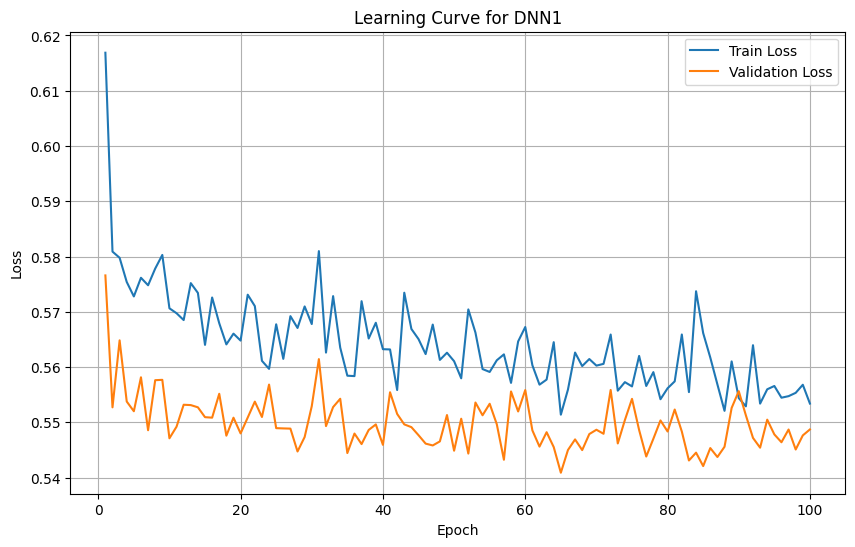

In [31]:
best_params=study.best_params
model = DNN(input_dim=X_train_tensor.shape[1],
            hidden_units=best_params["hidden_units"],
            dropout_rate=best_params["dropout_rate"]
            ).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.74%
Precision: 0.4766
Recall: 0.9617
F1 Score: 0.6373
Matthews Correlation Coefficient: 0.3491
Specificity: 0.3358


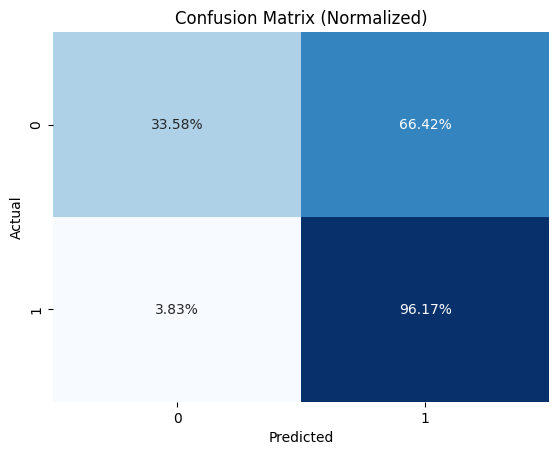

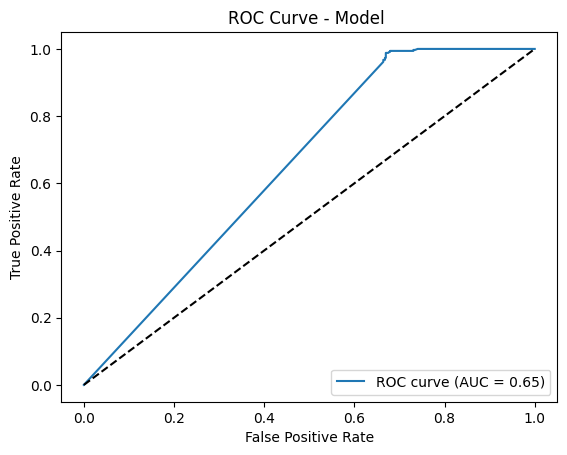

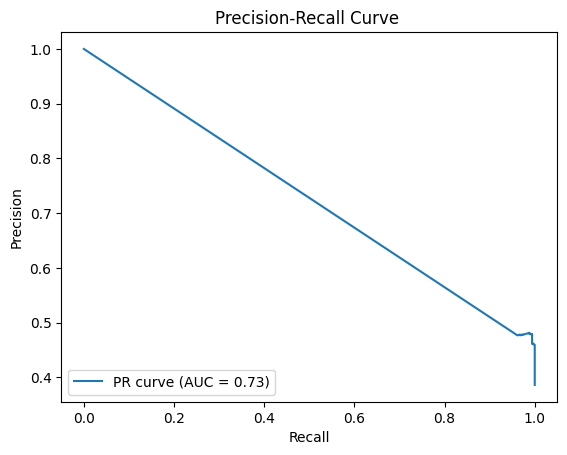

In [32]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [33]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_1.pth')
